In [1]:
library(ggplot2)
library(ggmap)
library(sp)
library(maptools)
library(rgdal)
library(rgeos)
library(RColorBrewer)
library(dplyr)
library(leaflet)
options(jupyter.plot_mimetypes = 'image/png')

Warning message:
: package ‘ggplot2’ was built under R version 3.2.4Checking rgeos availability: TRUE
rgdal: version: 1.1-8, (SVN revision 616)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 1.11.3, released 2015/09/16
 Path to GDAL shared files: /usr/local/Cellar/gdal/1.11.3_1/share/gdal
 Loaded PROJ.4 runtime: Rel. 4.9.2, 08 September 2015, [PJ_VERSION: 492]
 Path to PROJ.4 shared files: (autodetected)
 Linking to sp version: 1.2-2 
rgeos version: 0.3-19, (SVN revision 524)
 GEOS runtime version: 3.5.0-CAPI-1.9.0 r4084 
 Linking to sp version: 1.2-2 
 Polygon checking: TRUE 


Attaching package: ‘dplyr’

The following objects are masked from ‘package:rgeos’:

    intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
crime = read.csv('train.csv')
str(crime)

'data.frame':	878049 obs. of  9 variables:
 $ Dates     : Factor w/ 389257 levels "2003-01-06 00:01:00",..: 389257 389257 389256 389255 389255 389255 389255 389255 389254 389254 ...
 $ Category  : Factor w/ 39 levels "ARSON","ASSAULT",..: 38 22 22 17 17 17 37 37 17 17 ...
 $ Descript  : Factor w/ 879 levels "ABANDONMENT OF CHILD",..: 867 811 811 405 405 407 740 740 405 405 ...
 $ DayOfWeek : Factor w/ 7 levels "Friday","Monday",..: 7 7 7 7 7 7 7 7 7 7 ...
 $ PdDistrict: Factor w/ 10 levels "BAYVIEW","CENTRAL",..: 5 5 5 5 6 3 3 1 7 2 ...
 $ Resolution: Factor w/ 17 levels "ARREST, BOOKED",..: 1 1 1 12 12 12 12 12 12 12 ...
 $ Address   : Factor w/ 23228 levels "0 Block of  HARRISON ST",..: 19791 19791 22698 4267 1844 1506 13323 18055 11385 17659 ...
 $ X         : num  -122 -122 -122 -122 -122 ...
 $ Y         : num  37.8 37.8 37.8 37.8 37.8 ...


In [3]:
summary(crime$Category)

ARSON                     ASSAULT 
                       1513                       76876 
                 BAD CHECKS                     BRIBERY 
                        406                         289 
                   BURGLARY          DISORDERLY CONDUCT 
                      36755                        4320 
DRIVING UNDER THE INFLUENCE               DRUG/NARCOTIC 
                       2268                       53971 
                DRUNKENNESS                EMBEZZLEMENT 
                       4280                        1166 
                  EXTORTION             FAMILY OFFENSES 
                        256                         491 
     FORGERY/COUNTERFEITING                       FRAUD 
                      10609                       16679 
                   GAMBLING                  KIDNAPPING 
                        146                        2341 
              LARCENY/THEFT                 LIQUOR LAWS 
                     174900                        1903 
                  LOITERING              MISSING PERSON 
                       1225                       25989 
               NON-CRIMINAL              OTHER OFFENSES 
                      92304                      126182 
    PORNOGRAPHY/OBSCENE MAT                PROSTITUTION 
                         22                        7484 
          RECOVERED VEHICLE                     ROBBERY 
                       3138                       23000 
                    RUNAWAY             SECONDARY CODES 
                       1946                        9985 
      SEX OFFENSES FORCIBLE   SEX OFFENSES NON FORCIBLE 
                       4388                         148 
            STOLEN PROPERTY                     SUICIDE 
                       4540                         508 
             SUSPICIOUS OCC                        TREA 
                      31414                           6 
                   TRESPASS                   VANDALISM 
                       7326                       44725 
              VEHICLE THEFT                    WARRANTS 
                      53781                       42214 
                WEAPON LAWS 
                       8555

In [4]:
#remove those with Y=90.0
crime = crime[crime$Y!=90.0,]

# Use sp package and shape file

In [5]:
#convert to spatialpointsDataFrame with X/Y coordinate and WGS84 datum
coords = SpatialPoints(crime[,c('X','Y')])
crime_spatial = SpatialPointsDataFrame(coords,crime)
proj4string(crime_spatial) = CRS('+proj=longlat +ellps=WGS84')

In [6]:
str(crime_spatial)

Formal class 'SpatialPointsDataFrame' [package "sp"] with 5 slots
  ..@ data       :'data.frame':	877982 obs. of  9 variables:
  .. ..$ Dates     : Factor w/ 389257 levels "2003-01-06 00:01:00",..: 389257 389257 389256 389255 389255 389255 389255 389255 389254 389254 ...
  .. ..$ Category  : Factor w/ 39 levels "ARSON","ASSAULT",..: 38 22 22 17 17 17 37 37 17 17 ...
  .. ..$ Descript  : Factor w/ 879 levels "ABANDONMENT OF CHILD",..: 867 811 811 405 405 407 740 740 405 405 ...
  .. ..$ DayOfWeek : Factor w/ 7 levels "Friday","Monday",..: 7 7 7 7 7 7 7 7 7 7 ...
  .. ..$ PdDistrict: Factor w/ 10 levels "BAYVIEW","CENTRAL",..: 5 5 5 5 6 3 3 1 7 2 ...
  .. ..$ Resolution: Factor w/ 17 levels "ARREST, BOOKED",..: 1 1 1 12 12 12 12 12 12 12 ...
  .. ..$ Address   : Factor w/ 23228 levels "0 Block of  HARRISON ST",..: 19791 19791 22698 4267 1844 1506 13323 18055 11385 17659 ...
  .. ..$ X         : num [1:877982] -122 -122 -122 -122 -122 ...
  .. ..$ Y         : num [1:877982] 37.8 37.8 37.8

In [7]:
bbox(crime_spatial)

min        max
X -122.51364 -122.36494
Y   37.70788   37.81998

In [8]:
#read the shape file
ca_shp = readShapeSpatial('tl_2015_06_tract/tl_2015_06_tract.shp',proj4string = CRS('+proj=longlat +datum=WGS84'))

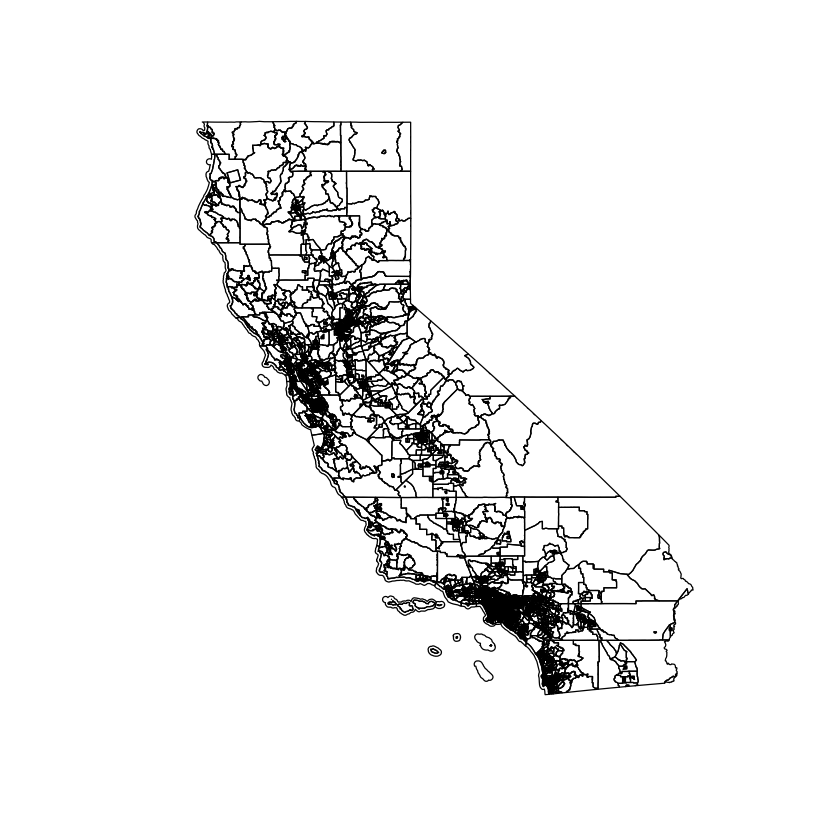

In [9]:
plot(ca_shp)

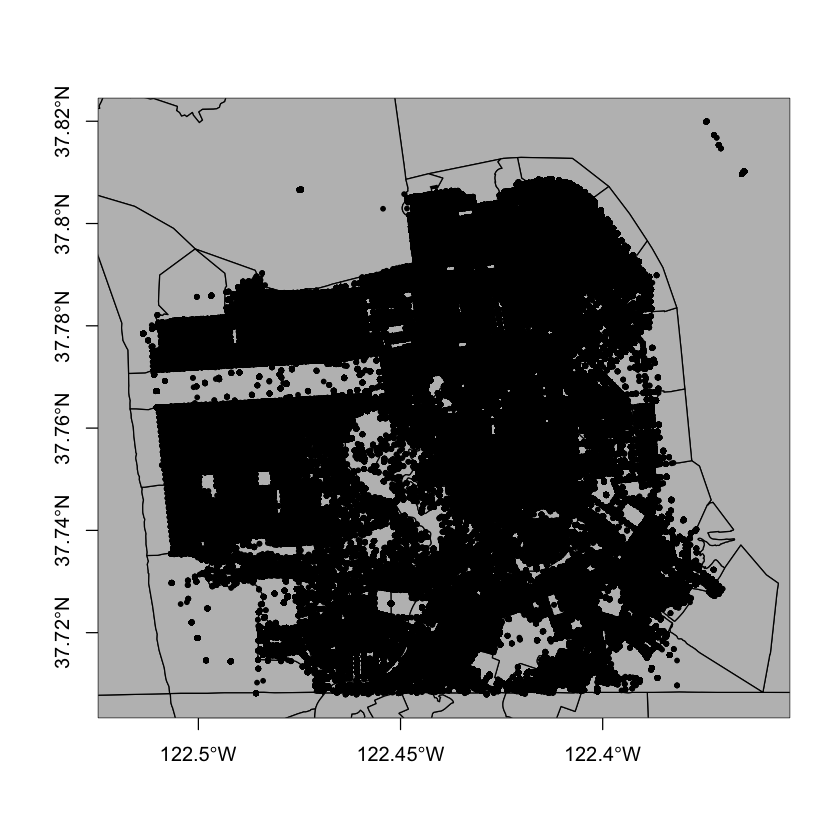

In [10]:
#restrict to san francisco area
plot(ca_shp,xlim=c(-122.5136, -122.3649), ylim=c(37.70788,37.81998),col='grey',axes=TRUE)
plot(crime_spatial, pch=21, b='red',cex=.5,add=TRUE)

# Use ggmap

In [11]:
#need to convert shape file first before using ggmap
ca_shp_df = fortify(ca_shp)

Regions defined for each Polygons


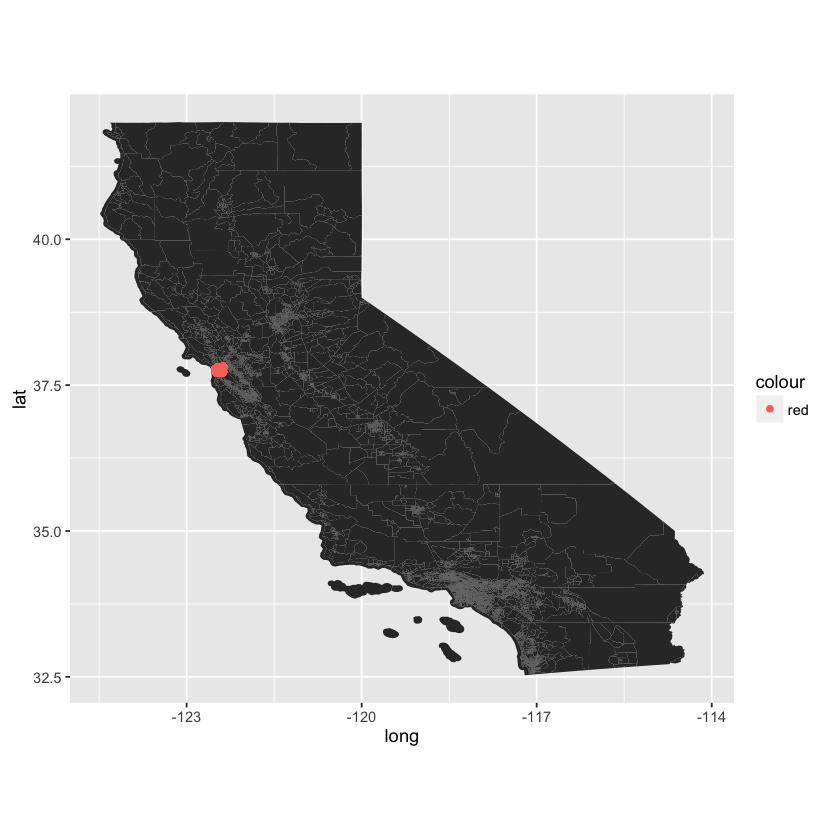

In [12]:
ggplot() + geom_polygon(data=ca_shp_df,aes(x=long,y=lat,group=group)) + coord_equal() + geom_point(data=crime,aes(x=X,y=Y,color='red'))

In [13]:
locations = c(left = -122.5222, 
                bottom = 37.7073, 
                right = -122.3481,
                top = 37.8381)
map_data = get_map(location=locations, zoom=12, source='osm',color='bw')

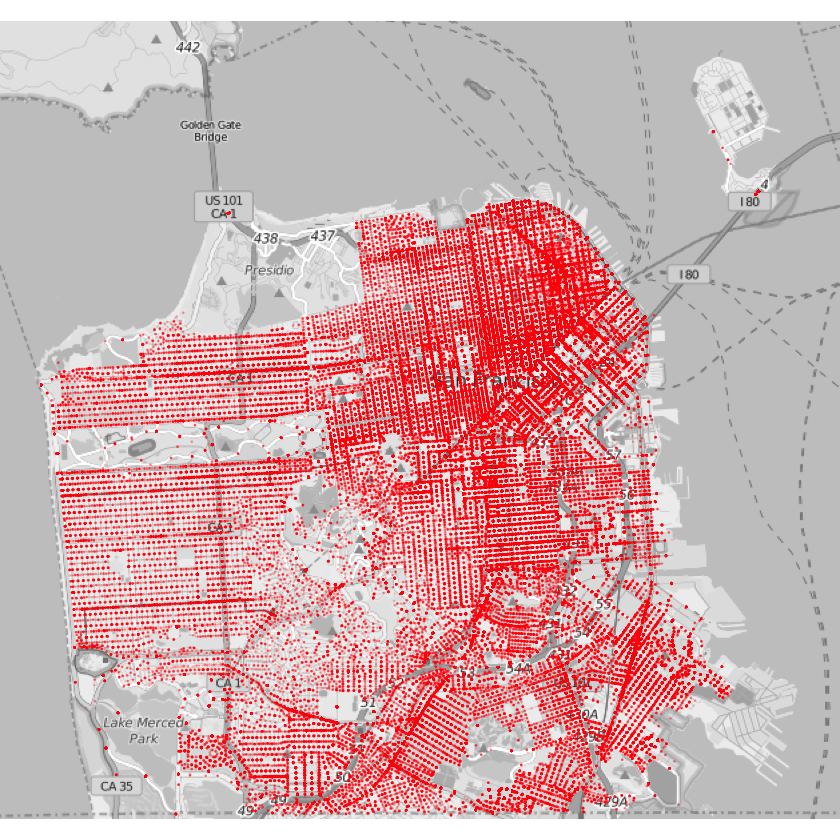

In [14]:
ggmap(map_data,extent='device') + 
geom_point(aes(x=X,y=Y),data=crime,alpha=0.1,color='red',size=0.1)

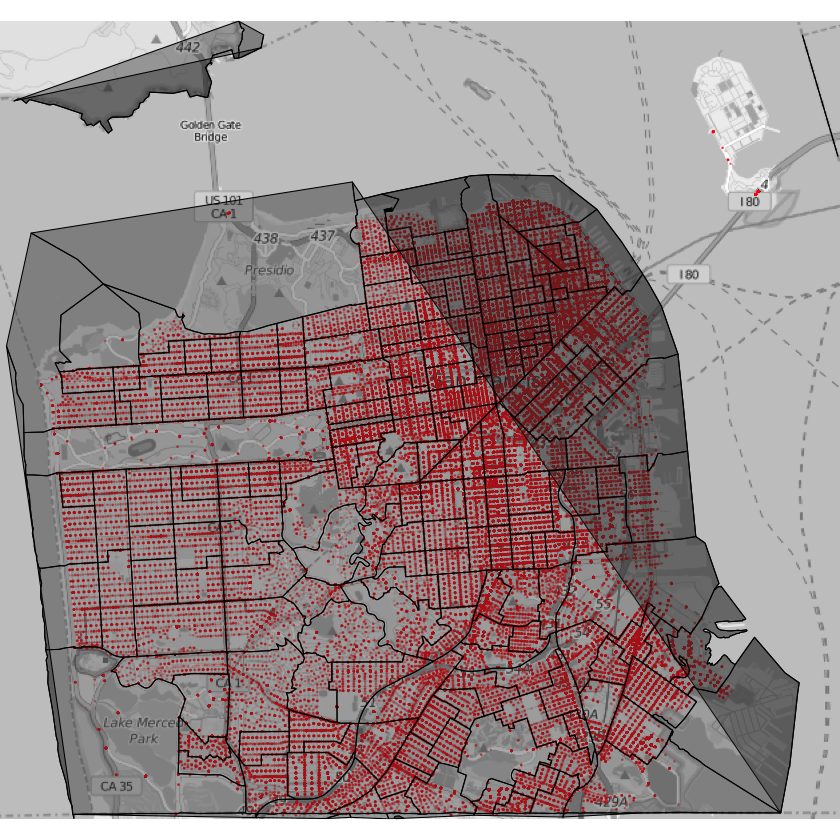

In [15]:
#add the shape file
ggmap(map_data,extent='device') + 
geom_point(aes(x=X,y=Y),data=crime,alpha=0.1,color='red',size=0.1) +
geom_polygon(aes(x = long, y = lat, group = group), data = ca_shp_df, colour = "black", 
               alpha = .4, size = .3)


# Map selected categories of crime

In [17]:
map_crime = function(df, categories){
	filtered = filter(df, Category %in% categories)
	plot = ggmap(map_data, extent='device') + geom_point(data=filtered, aes(x=X,y=Y,color=Category),alpha=0.1,size=0.1)
	return(plot)
}

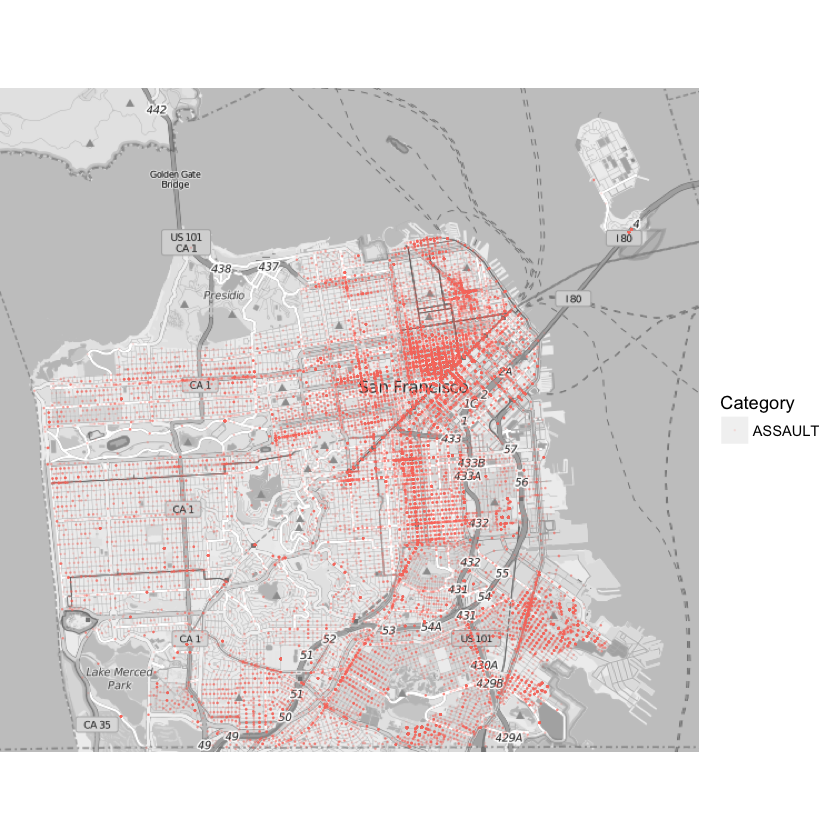

In [18]:
map_crime(crime, 'ASSAULT')

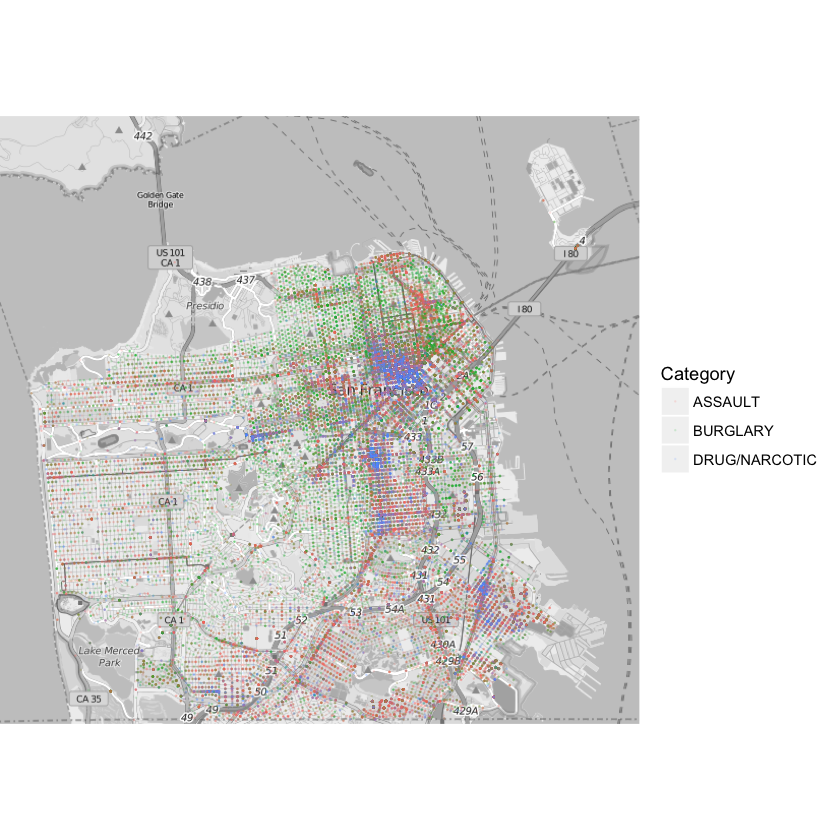

In [19]:
map_crime(crime, c('ASSAULT','DRUG/NARCOTIC','BURGLARY'))

# Plot density of crime

In [20]:
crime_subset = filter(crime, Category %in% c('ASSAULT','DRUG/NARCOTIC','BURGLARY'))
dim(crime_subset)

[1] 167597      9

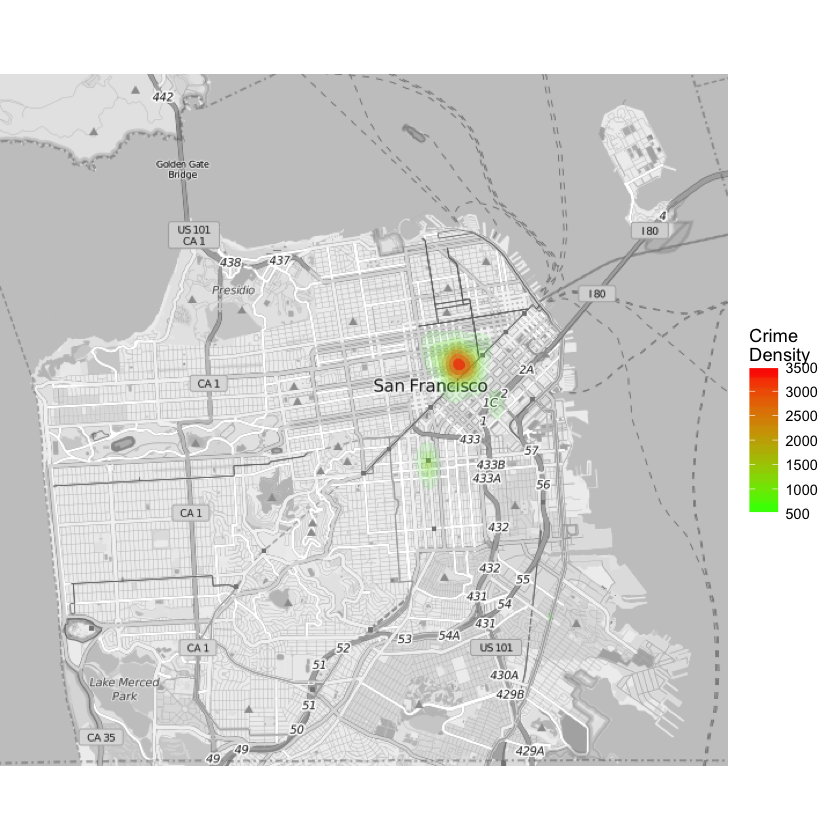

In [21]:
contours <- stat_density2d(
aes(x = X, y = Y, fill = ..level.., alpha=..level..),
size = 0.1, data = crime_subset, n=200,
geom = "polygon")

ggmap(map_data, extent='device') + contours +
scale_alpha_continuous(range=c(0.1,0.5), guide='none') +
scale_fill_gradient('Crime\nDensity',low="green",high="red")

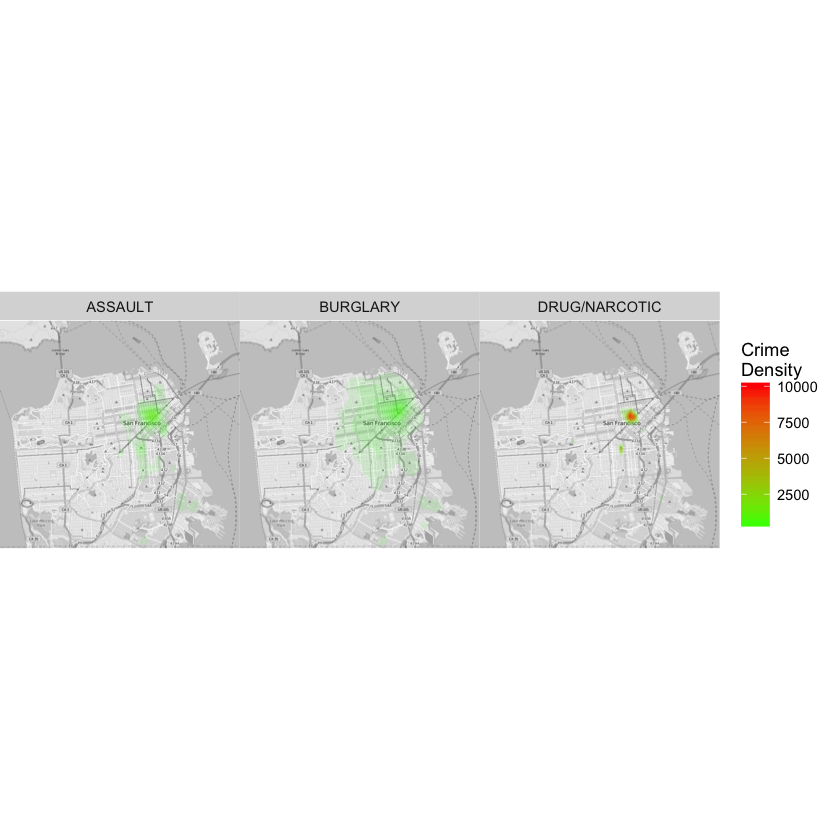

In [22]:
ggmap(map_data, extent='device') + contours +
scale_alpha_continuous(range=c(0.1,0.5), guide='none') +
scale_fill_gradient('Crime\nDensity',low="green",high="red") +
facet_wrap(~Category)